In [2]:
import os, sys, math, itertools, random, pathlib, time
from pprint import pprint

# Numerics / plotting
import numpy as np
import matplotlib.pyplot as plt

# ML / DL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Metrics & reports
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Reproducibility
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("TensorFlow:", tf.__version__)


TensorFlow: 2.18.0


In [4]:
DATA_DIR = "/kaggle/input/gtsrb-german-traffic-sign/Train"

IMG_SIZE = (64, 64)    # common size for GTSRB (fast + good)
BATCH_SIZE = 64
NUM_CLASSES = None  # will be inferred
AUTOTUNE = tf.data.AUTOTUNE

assert os.path.isdir(DATA_DIR), f"DATA_DIR not found: {DATA_DIR}"
class_subdirs = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
NUM_CLASSES = len(class_subdirs)
print(f"Found {NUM_CLASSES} classes.")
print("Sample classes:", class_subdirs[:10])


Found 43 classes.
Sample classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17']


### We'll create an 80/20 split, then split the 20% into 10% val and 10% test

In [6]:

VAL_SPLIT = 0.20

full_train = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset='training'
)

val_plus_test = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset='validation'
)

# Split the 20% into two equal halves: 10% val, 10% test
val_batches = int(0.5 * tf.data.experimental.cardinality(val_plus_test).numpy())
val_ds = val_plus_test.take(val_batches)
test_ds = val_plus_test.skip(val_batches)

class_names = full_train.class_names
NUM_CLASSES = len(class_names)
print("Classes:", NUM_CLASSES)
print("Train batches:", tf.data.experimental.cardinality(full_train).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

# Cache + prefetch for speed
def optimize(ds):
    return ds.cache().prefetch(AUTOTUNE)

train_ds = optimize(full_train)
val_ds   = optimize(val_ds)
test_ds  = optimize(test_ds)


Found 39209 files belonging to 43 classes.
Using 31368 files for training.


I0000 00:00:1756731460.782457      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756731460.783135      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 39209 files belonging to 43 classes.
Using 7841 files for validation.
Classes: 43
Train batches: 491
Val batches: 61
Test batches: 62


#### some labels with images

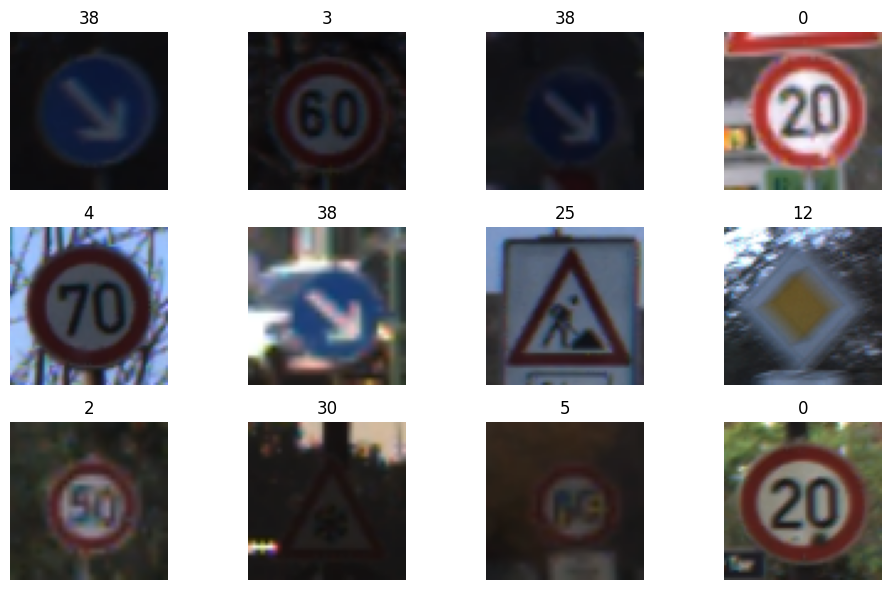

In [7]:
images, labels = next(iter(train_ds))
plt.figure(figsize=(10, 6))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()


### Augmentation with data rescaling

In [8]:
# Normalization: rescale pixels to [0, 1]
normalization = layers.Rescaling(1./255)

# Augmentation (applied only on training)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05),
])

# Wrap datasets with normalization (augmentation added inside model for training only)
def preprocess(ds, augment=False):
    def _map(x, y):
        x = normalization(x)
        if augment:
            x = data_augmentation(x, training=True)
        return x, y
    return ds.map(_map, num_parallel_calls=AUTOTUNE)

train_ds_prep = preprocess(train_ds, augment=True)
val_ds_prep   = preprocess(val_ds, augment=False)
test_ds_prep  = preprocess(test_ds, augment=False)


In [9]:
custom_cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


### Training CNN Model

In [8]:
EPOCHS_CNN = 15

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True, verbose=1)
]

history_cnn = custom_cnn.fit(
    train_ds_prep,
    validation_data=val_ds_prep,
    epochs=EPOCHS_CNN,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 365s 734ms/step - accuracy: 0.0984 - loss: 3.3090 - val_accuracy: 0.3222 - val_loss: 2.2124 - learning_rate: 0.0010
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 344s 700ms/step - accuracy: 0.3537 - loss: 2.0342 - val_accuracy: 0.5451 - val_loss: 1.3381 - learning_rate: 0.0010
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 344s 699ms/step - accuracy: 0.5496 - loss: 1.3385 - val_accuracy: 0.7897 - val_loss: 0.6165 - learning_rate: 0.0010
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 344s 701ms/step - accuracy: 0.7408 - loss: 0.7620 - val_accuracy: 0.8911 - val_loss: 0.3169 - learning_rate: 0.0010
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 346s 705ms/step - accuracy: 0.8516 - loss: 0.4565 - val_accuracy: 0.9247 - val_loss: 0.2112 - learning_rate: 0.0010
Epoch 6/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 349s 710ms/step - accuracy: 0.8946 - loss: 0.3204 - val_accuracy: 0.9485 - val_loss: 0.1688 - learning_rate: 0.0010
Epoch 7/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 342s 697ms/step - accura

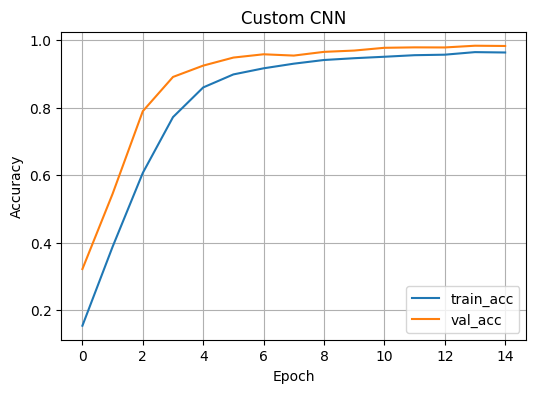

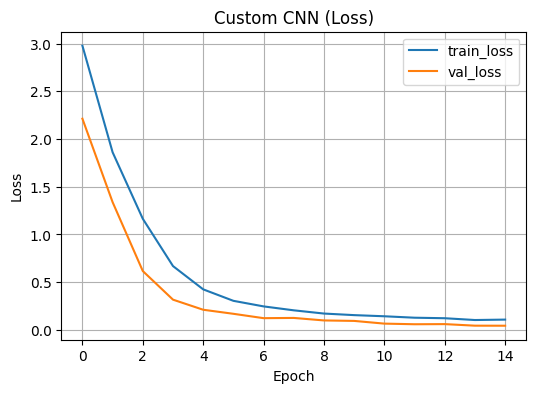

In [11]:
def plot_history(h, title="Training History"):
    plt.figure(figsize=(6,4))
    plt.plot(h.history["accuracy"], label="train_acc")
    plt.plot(h.history["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(h.history["loss"], label="train_loss")
    plt.plot(h.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title + " (Loss)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history_cnn, title="Custom CNN")


### CNN Test Accuracy

In [12]:
test_loss_cnn, test_acc_cnn = custom_cnn.evaluate(test_ds_prep, verbose=0)
print(f"Custom CNN — Test Accuracy: {test_acc_cnn:.4f}, Test Loss: {test_loss_cnn:.4f}")


Custom CNN — Test Accuracy: 0.9840, Test Loss: 0.0455


## Collect true labels and predictions

In [14]:
y_true, y_pred = [], []
for batch_x, batch_y in test_ds_prep:
    preds = custom_cnn.predict(batch_x, verbose=0)
    y_true.extend(batch_y.numpy().tolist())
    y_pred.extend(np.argmax(preds, axis=1).tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm_cnn = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
acc_cnn = accuracy_score(y_true, y_pred)

print(f"Custom CNN — Accuracy check: {acc_cnn:.4f}")
print(classification_report(y_true, y_pred, target_names=[str(c) for c in class_names][:NUM_CLASSES])[:1000], "...")

Custom CNN — Accuracy check: 0.9840
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        28
           1       1.00      0.99      1.00       222
          10       1.00      1.00      1.00       176
          11       1.00      1.00      1.00       139
          12       0.99      1.00      1.00       199
          13       1.00      1.00      1.00       208
          14       1.00      1.00      1.00        95
          15       1.00      0.95      0.97        78
          16       1.00      1.00      1.00        37
          17       1.00      1.00      1.00       107
          18       0.99      0.98      0.99       123
          19       0.72      0.72      0.72        18
           2       1.00      1.00      1.00       199
          20       0.82      0.80      0.81        35
          21       1.00      0.97      0.99        34
          22       1.00      1.00      1.00        39
          23       0.96      1.00      0.98  

### Confusion Matrix

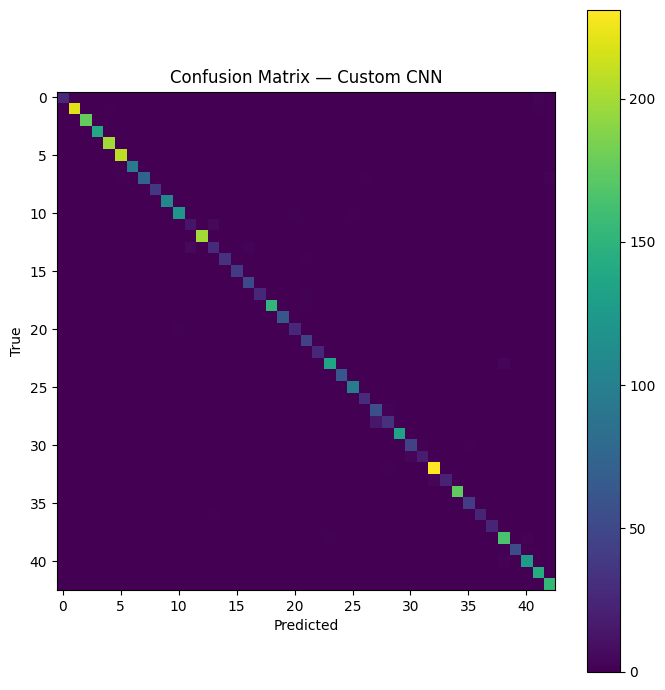

In [15]:
# (compact, because GTSRB has many classes)
fig = plt.figure(figsize=(7,7))
plt.imshow(cm_cnn, interpolation='nearest')
plt.title("Confusion Matrix — Custom CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()


### Define constants for MobileNetV2 (Transfer Learning)

In [16]:
IMG_SIZE_MBV2 = (224, 224)   # MobileNetV2 expects 224x224 images
NUM_CLASSES = len(class_names)  # same as CNN


### New augmentation pipeline (different from CNN one)

In [17]:
data_augmentation_mbv2 = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="data_augmentation_mbv2")


### Build MobileNetV2 model

In [18]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE_MBV2 + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze base (Stage 1)

inputs = keras.Input(shape=IMG_SIZE_MBV2 + (3,))
x = data_augmentation_mbv2(inputs, training=True)  
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

mobilenet_model = keras.Model(inputs, outputs, name="MobileNetV2_GTSRB")
mobilenet_model.summary()


Model: "MobileNetV2_GTSRB"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_mbv2          │ (None, 224, 224, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 43)             │        55,083 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,313,067 (8.82 MB)

 Trainable params: 55,083 (215.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

###  Compile MobileNetV2 model (Stage 1: base frozen)

In [19]:
mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


### Train MobileNetV2 (Stage 1)

In [20]:
EPOCHS_STAGE1 = 8

history_mbv2_stage1 = mobilenet_model.fit(
    train_ds.map(lambda x, y: (tf.image.resize(x, IMG_SIZE_MBV2), y)),
    validation_data=val_ds.map(lambda x, y: (tf.image.resize(x, IMG_SIZE_MBV2), y)),
    epochs=EPOCHS_STAGE1
)


Epoch 1/8
491/491 ━━━━━━━━━━━━━━━━━━━━ 72s 127ms/step - accuracy: 0.1887 - loss: 3.1349 - val_accuracy: 0.5364 - val_loss: 1.6865
Epoch 2/8
491/491 ━━━━━━━━━━━━━━━━━━━━ 60s 122ms/step - accuracy: 0.5078 - loss: 1.6828 - val_accuracy: 0.6644 - val_loss: 1.2492
Epoch 3/8
491/491 ━━━━━━━━━━━━━━━━━━━━ 60s 122ms/step - accuracy: 0.6083 - loss: 1.3114 - val_accuracy: 0.7277 - val_loss: 1.0358
Epoch 4/8
491/491 ━━━━━━━━━━━━━━━━━━━━ 60s 122ms/step - accuracy: 0.6638 - loss: 1.1163 - val_accuracy: 0.7628 - val_loss: 0.9068
Epoch 5/8
491/491 ━━━━━━━━━━━━━━━━━━━━ 60s 122ms/step - accuracy: 0.7044 - loss: 0.9887 - val_accuracy: 0.7882 - val_loss: 0.8130
Epoch 6/8
491/491 ━━━━━━━━━━━━━━━━━━━━ 60s 122ms/step - accuracy: 0.7250 - loss: 0.9052 - val_accuracy: 0.8012 - val_loss: 0.7428
Epoch 7/8
491/491 ━━━━━━━━━━━━━━━━━━━━ 60s 122ms/step - accuracy: 0.7483 - loss: 0.8360 - val_accuracy: 0.8169 - val_loss: 0.6907
Epoch 8/8
491/491 ━━━━━━━━━━━━━━━━━━━━ 60s 122ms/step - accuracy: 0.7702 - loss: 0.7745 - 

### Fine-tune (Stage 2)

In [21]:
base_model.trainable = True

# Freeze all layers except top 50 (you can adjust)
for layer in base_model.layers[:-50]:
    layer.trainable = False

mobilenet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_STAGE2 = 10

history_mbv2_stage2 = mobilenet_model.fit(
    train_ds.map(lambda x, y: (tf.image.resize(x, IMG_SIZE_MBV2), y)),
    validation_data=val_ds.map(lambda x, y: (tf.image.resize(x, IMG_SIZE_MBV2), y)),
    epochs=EPOCHS_STAGE2
)


Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 110s 187ms/step - accuracy: 0.6395 - loss: 1.2319 - val_accuracy: 0.8179 - val_loss: 0.5452
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 90s 182ms/step - accuracy: 0.8460 - loss: 0.5073 - val_accuracy: 0.8998 - val_loss: 0.3202
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 90s 182ms/step - accuracy: 0.8981 - loss: 0.3402 - val_accuracy: 0.9344 - val_loss: 0.2188
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 90s 183ms/step - accuracy: 0.9292 - loss: 0.2427 - val_accuracy: 0.9490 - val_loss: 0.1629
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 90s 182ms/step - accuracy: 0.9414 - loss: 0.1927 - val_accuracy: 0.9575 - val_loss: 0.1289
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 90s 182ms/step - accuracy: 0.9542 - loss: 0.1526 - val_accuracy: 0.9657 - val_loss: 0.1102
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 90s 182ms/step - accuracy: 0.9619 - loss: 0.1294 - val_accuracy: 0.9708 - val_loss: 0.0905
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 90s 182ms/step - accuracy: 0.9688 - loss: 

### Evaluate on test set

In [22]:
test_loss, test_acc = mobilenet_model.evaluate(
    test_ds.map(lambda x, y: (tf.image.resize(x, IMG_SIZE_MBV2), y))
)
print(f" Test Accuracy with MobileNetV2: {test_acc:.4f}")


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.9798 - loss: 0.0611
 Test Accuracy with MobileNetV2: 0.9830


### Accuracy & Loss Graph

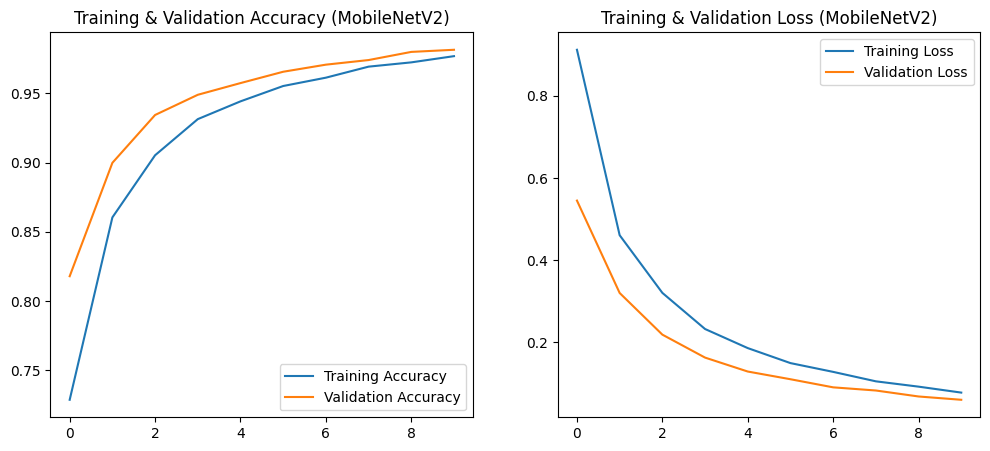

In [29]:
acc = history_mbv2_stage2.history['accuracy']
val_acc = history_mbv2_stage2.history['val_accuracy']
loss = history_mbv2_stage2.history['loss']
val_loss = history_mbv2_stage2.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy (MobileNetV2)')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss (MobileNetV2)')

plt.show()


### Generate confusion matrix

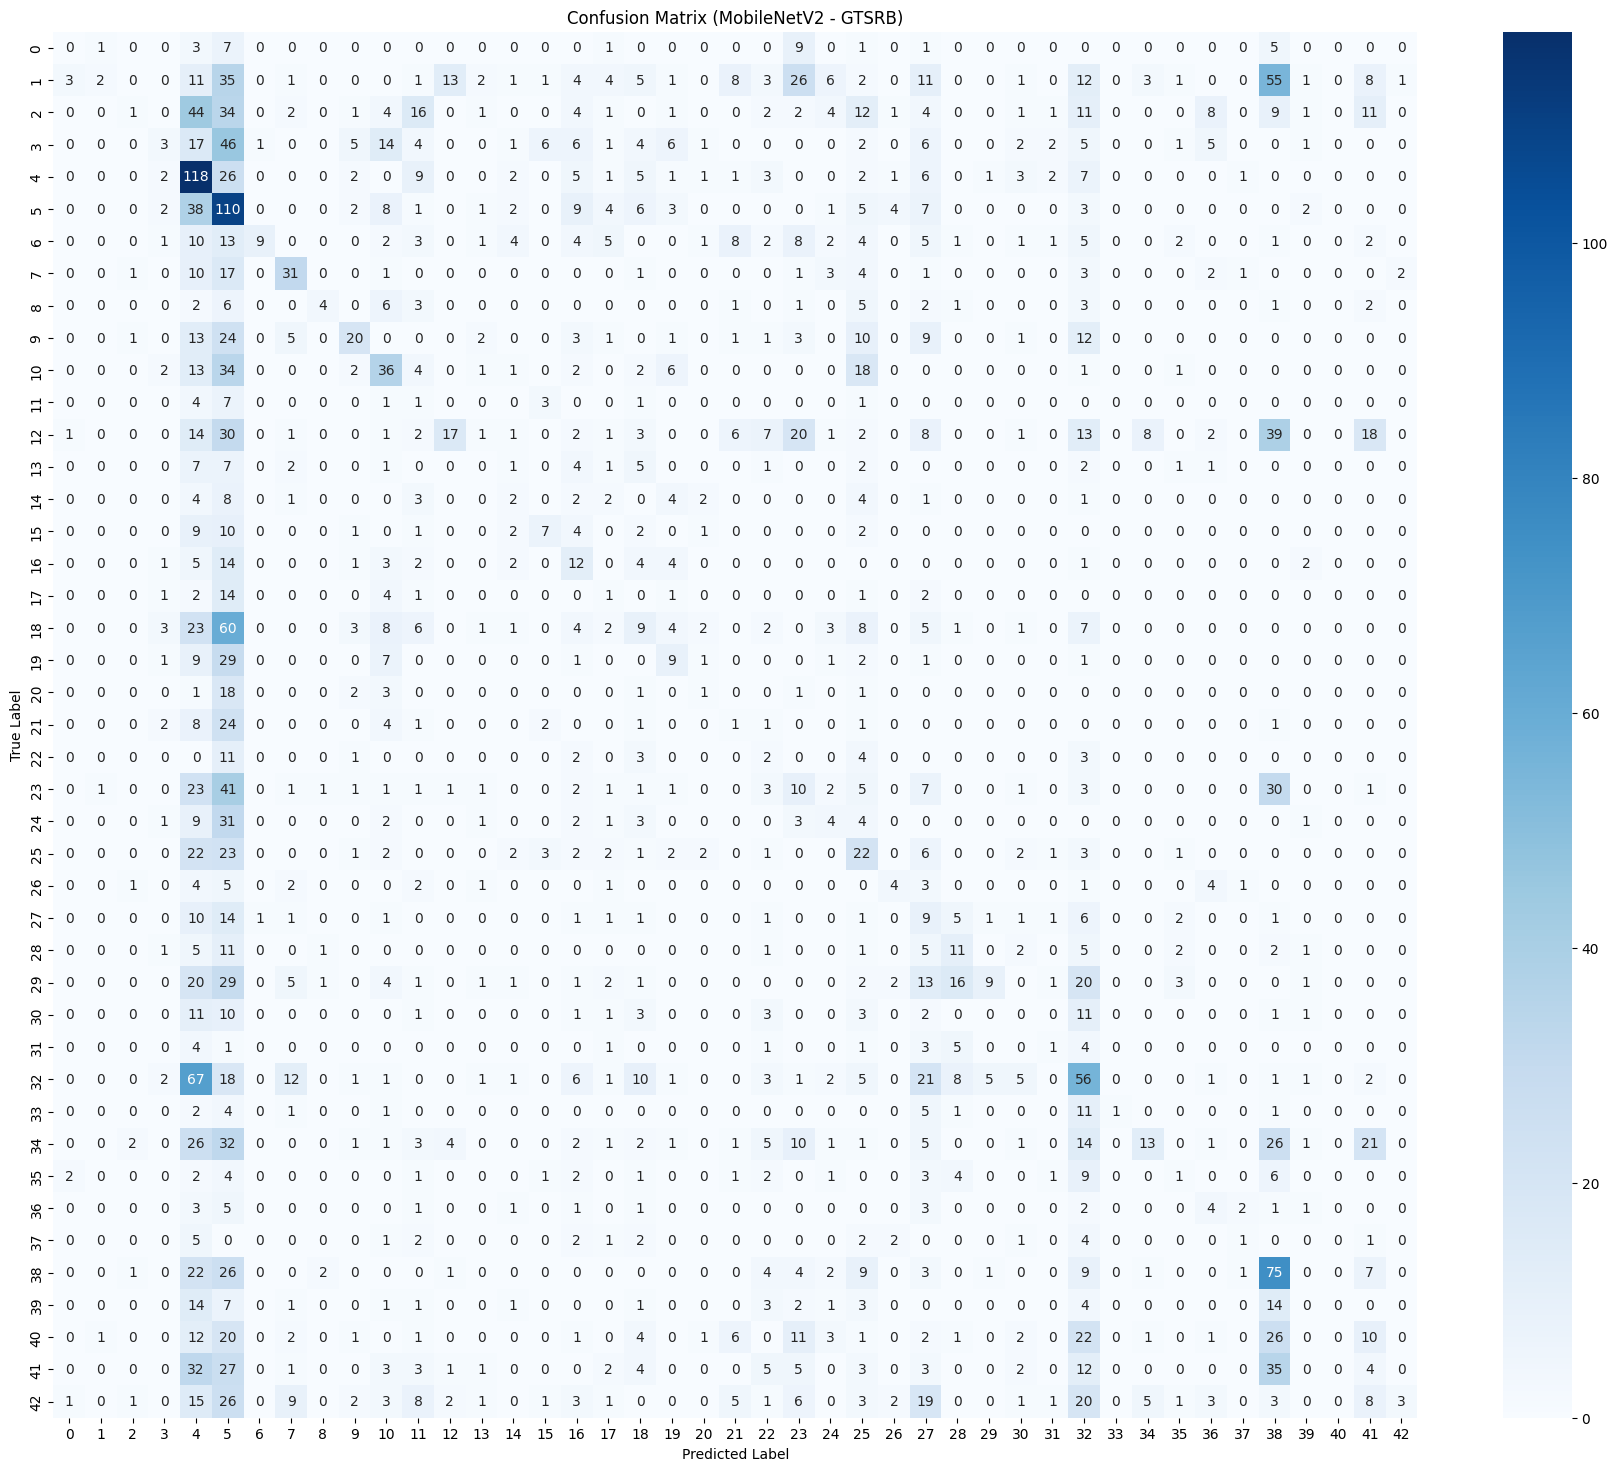

In [39]:
cm = confusion_matrix(y_true, y_pred)

# Class labels (43 classes: 0,1,2,...,42)
class_labels = [str(i) for i in range(43)]

# Normalize for better visibility (optional)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix (raw values)
plt.figure(figsize=(22, 18))  # Bigger size for 43x43 classes
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (MobileNetV2 - GTSRB)")
plt.show()

